# Week 4: CNN

There are **3 main ways** to **build, train and deploy NN** in **AWS SageMaker**

1. Using the built-in algorithms in AWS SageMaker (discuss in half of Week 4 and Week 5)
    - Restrictive in desgining model framework
    - You don't need in depth knowlegde of the framework, you just need to know sagemaker syntax. 
2. Using your own framework code (your own script) in AWS SageMaker (similar to Week 2 and Week 3)
    - Less restrictive in the structure of the model - *e.g.* number of hidden layers
    - Requires knowledge of the framework
3. Using your own algorithms and code 
    - This requires knowledge on using your own container, which is out of scope of this subject(https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers-notebooks.html)
    - Offers a lot of flexibility in designing your own framework


### Today's collaborate 
1.  Today we are going to use AWS SageMaker to build, train and deploy a CNN using our own framework code (which is similar to week 2 and 3).
2.  How to convert an image into numpy array using Keras.
3.  How to convert image to the image format that we can use to train the **built-in Computer Vision classification NN in SageMaker.** Note: if you don't want to use their built-in script, you can use your script (refer to Kelly's Week 4 collorate - slide 23)  


### 1. Build, train and deploy a CNN model using our own script in AWS SageMaker (similar to week 2 and 3)
Data
- MNIST fashion data contains 60,000 small square 28 × 28 pixel grayscale images of 10 types of clothing, such as shoes, t-shirts, dresses, and more.
- All the code here is run on kernel **conda_tensorflow_p36** configuration

In [7]:
%%sh
sudo chown ec2-user lost+found
sudo chgrp ec2-user lost+found

In [2]:
# We first need to import the necessary libraries and define some environment variables  
## Import sagemaker and retrieve IAM role, which determines your user identity and permissions
import os
import sagemaker #import sagemaker  
from sagemaker import get_execution_role
print(sagemaker.__version__) #print the sagemaker version
sagemaker_session = sagemaker.Session() ### Manages interactions with the Amazon SageMaker APIs and 
                           ### any other AWS services needed e.g. S3
role = sagemaker.get_execution_role() ### Get and save the IAM role as environment variable

2.41.0


In [3]:
## Import os, keras, numpy, pyplot and the fashion MNIST data 
import os
import keras
import numpy as np
from keras.datasets import fashion_mnist
from matplotlib import pyplot
(x_train, y_train), (x_val, y_val) = fashion_mnist.load_data()

Using TensorFlow backend.



4423680/4422102 [==============================] - 3s 1us/step


x_train_shape & data type: ((60000, 28, 28), dtype('uint8'))
y_train_shape & data type: ((60000,), dtype('uint8'))


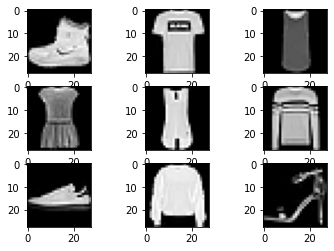

In [4]:
# Take a quick look at data 

#Each image is represented as a 28x28 pixel grayscale images
## View shape and type of data
xtr = x_train.shape, x_train.dtype
ytr = y_train.shape, y_train.dtype

print("x_train_shape & data type:", xtr)
print("y_train_shape & data type:", ytr)

# plot some raw pixel data
for i in range(9):
  
    pyplot.subplot(330 + 1 + i)

    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))

In [6]:
# Create local directory for the data and save the test and training data here
# Note: No need to do this if you have already stored the fashion mnist data in S3, so hashtagged out.
os.makedirs("./data", exist_ok=True)
np.savez('./data/training', image = x_train, label=y_train)
np.savez('./data/test', image=x_val, label=y_val)

In [8]:
%%sh
ls -l

total 100
drwxrwxr-x 2 ec2-user ec2-user  4096 May 27 03:33 data
drwx------ 2 ec2-user ec2-user 16384 May 27 02:28 lost+found
-rw-rw-r-- 1 ec2-user ec2-user  4416 May 27 02:33 mnist_fashion_cnn_tf2.py
-rw-rw-r-- 1 ec2-user ec2-user 71126 May 27 03:34 Prac4_SageMaker_CNN_MC.ipynb


We are now going to train our model on the local instance - this is an optional step and is to check if our code will run on AWS. We train the model using TensorFlow() to create a tf_estimator object. 

In [15]:
## We will use the a modified version of the python script that made in Lab 1 to train our CNN model. 
## If you haven't already uploaded this into your notebook instance then do that now. 

## Take a look at that script... 

#Import tensorflow from sagemaker
from sagemaker.tensorflow import TensorFlow

#Set environment variables - file paths to data and for output
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'
output = 'file:///tmp'

tf_estimator = TensorFlow(entry_point='mnist_fashion_cnn_tf2.py', #path to local python source file to be executed
                          base_job_name='CNN-local', #name the job for job management                                                      
                          role = role, #the IAM ROLE ARN for the model - unique user ID
                          source_dir ='.', #path to the directory where any other dependancies are apart from entry point
                          instance_count = 1, #the number of EC2 intances to use
                          instance_type ='local', # Type of EC2 instance to use local = this one! 
                          framework_version = '2.1.0', # Tensorflow version for executing your tf code
                          py_version ='py3', #version of python for executing your model training code
                          script_mode =True, #enables us to use our python script to train the model
                          hyperparameters={'epochs': 1}, #hyperparameters used by our custom TensorFlow code during model training
                          output_path = output) #location for saving the results. Default = saved in the default S3 bucket.

#Note, Estimator is a high level interface for SageMaker training

In [16]:
#fit is used to train the model saved in the estimator object. We pass in file paths to the 
#trainng and test data (in this example they are stored locally)

tf_estimator.fit({'training': local_training_input_path, 'validation': local_test_input_path})

Creating t20nb2gzfd-algo-1-vo88q ... 
Creating t20nb2gzfd-algo-1-vo88q ... done
Attaching to t20nb2gzfd-algo-1-vo88q
t20nb2gzfd-algo-1-vo88q | 2021-05-27 03:46:11,605 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
t20nb2gzfd-algo-1-vo88q | 2021-05-27 03:46:11,613 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
t20nb2gzfd-algo-1-vo88q | 2021-05-27 03:46:12,676 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
t20nb2gzfd-algo-1-vo88q | 2021-05-27 03:46:12,695 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
t20nb2gzfd-algo-1-vo88q | 2021-05-27 03:46:12,712 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
t20nb2gzfd-algo-1-vo88q | 2021-05-27 03:46:12,724 sagemaker-containers INFO     Invoking user script
t20nb2gzfd-algo-1-vo88q | 
t20nb2gzfd-algo-1-vo88q | Training Env:
t20nb2gzfd-algo-1-vo88q | 
t20nb2gzfd-algo-1-vo88q | {
t20nb2gzfd-al

### Train the model in AWS



In [17]:
# Upload data to S3 bucket
## If you already ran the week 2 lab and stored the data in S3 then you can skip uploading the data and 
## just enter the same keys for the data as last week. 

#SAVE DATA TO S3
#prefix = 'keras-mnist-fashion' #first define a prefix for the key (think of this like a directory or file path)

#upload a local file/directory to S3 using upload_data(). 
##inputs = path, bucket (if not specifified will use default_bucket), optional prefix for directory structure
#training_input_path = sess.upload_data('data/training.npz', key_prefix = prefix+'/training')

#test_input_path = sess.upload_data('data/test.npz', key_prefix = prefix+'/validation')

#OR; DEFINE KEY TO EXISTING S3 - look in S3 section of AWS

training_input_path = 's3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/training/training.npz'
test_input_path = 's3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/validation/test.npz'

#CHECK PATHS
print(training_input_path)
print(test_input_path)

s3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/training/training.npz
s3://sagemaker-ap-southeast-2-580121432832/keras-mnist-fashion/validation/test.npz


### Configuring metrics from the job logs

Sagemaker can get training metrics directly from the logs and send them to the Cloudwatch metrics

In [18]:
keras_metric_definition = [
    {'Name': 'train:loss', 'Regex': '.*loss: ([0-9\\.]+) - accuracy: [0-9\\.]+.*'},
    {'Name': 'train:accuracy', 'Regex': '.*loss: [0-9\\.]+ - accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:accuracy', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: ([0-9\\.]+).*'},
    {'Name': 'validation:loss', 'Regex': '.*step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: ([0-9\\.]+) - val_accuracy: [0-9\\.]+.*'},
    {'Name': 'sec/steps', 'Regex': '.* (\d+)[mu]s/step - loss: [0-9\\.]+ - accuracy: [0-9\\.]+ - val_loss: [0-9\\.]+ - val_accuracy: [0-9\\.]+'}
]

### Train with managed instances

Used [managed spot instance](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/using-spot-instances.html) to save money. 

In [19]:
tf_estimator = TensorFlow(entry_point='mnist_fashion_cnn_tf2.py',  #Python script
                          base_job_name='CNN-example',
                          source_dir = '.',
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m4.xlarge', # instance type
                          framework_version='2.1.0', # Tensorflow version
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 3},
                          metric_definitions=keras_metric_definition,
                          ## after this line, everything is optional for managed spot instance
                          use_spot_instances=True,        # Use spot instance
                          max_run=3600,                    # Max training time
                          max_wait=7200,                  # Max training time + spot waiting time
                         ) 

In [20]:
tf_estimator.fit({'training': training_input_path, 'validation': test_input_path})   

2021-05-27 04:21:43 Starting - Starting the training job...ProfilerReport-1622089278: InProgress
...
2021-05-27 04:22:16 Starting - Launching requested ML instances......
2021-05-27 04:23:30 Starting - Preparing the instances for training...............
2021-05-27 04:26:10 Downloading - Downloading input data
2021-05-27 04:26:10 Training - Downloading the training image..2021-05-27 04:26:23,364 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-05-27 04:26:23,371 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-27 04:26:24,685 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-27 04:26:24,703 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-27 04:26:24,721 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-05-27 04:26:24,739 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_

The **fit** will create a training job "CNN-example

### Deploy the model

Similar to Week 2 and 3. Remember to delete the endpoint


In [ ]:
# Use code from weeks 2 and 3 to achieve this. 

### 2. Manipulating images  with Keras

Download image Basecamp.jpg. We now learn how to convert the image in jpg format to numpy array to prepare the data for NN training.

- It is not usual that we will get examples images like the mnist datasets, usually we would have our own data or images that we want to use to train a model.
- In this case, you need to be able to convert images into numpy array format. 

<class 'PIL.JpegImagePlugin.JpegImageFile'>
JPEG
(2016, 1512)


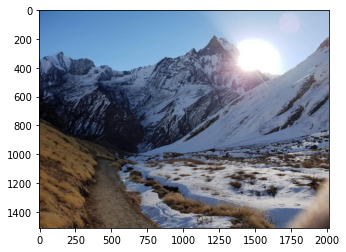

In [26]:
# we use the load_img function from keras.preprocessing.image to load images
from keras.preprocessing.image import load_img
img = load_img('Basecamp.jpg') #loads an image into Python Imaging Library (PIL) format 
print(type(img))
print(img.format)
print(img.size)
pyplot.imshow(img)

#### Convert the image to numpy array

In [27]:
from keras.preprocessing.image import img_to_array # image to pixels range from 0-255. Don't forget to scale for NN!
from keras.preprocessing.image import array_to_img # pixels to image
# convert to numpy array

img_array = img_to_array(img) # Converts a PIL Image instance to a Numpy array.

print(img_array.dtype) # data type
print(img_array.shape) # shape - outputs (height, width, channel)
print(img_array) # print the array

# convert to PIL Image
img_2 = array_to_img(img_array)

float32
(1512, 2016, 3)
[[[ 60. 109. 175.]
  [ 60. 109. 175.]
  [ 60. 109. 175.]
  ...
  [165. 185. 218.]
  [165. 185. 218.]
  [165. 185. 218.]]

 [[ 60. 109. 175.]
  [ 60. 109. 175.]
  [ 60. 109. 175.]
  ...
  [165. 185. 218.]
  [165. 185. 218.]
  [165. 185. 218.]]

 [[ 60. 109. 175.]
  [ 60. 109. 175.]
  [ 60. 109. 175.]
  ...
  [165. 185. 218.]
  [165. 185. 218.]
  [165. 185. 218.]]

 ...

 [[115.  85.  51.]
  [114.  84.  50.]
  [114.  84.  50.]
  ...
  [ 57.  39.  37.]
  [ 57.  39.  37.]
  [ 57.  39.  37.]]

 [[111.  81.  47.]
  [111.  81.  47.]
  [112.  82.  48.]
  ...
  [ 57.  39.  37.]
  [ 57.  39.  37.]
  [ 57.  39.  37.]]

 [[108.  78.  44.]
  [108.  78.  44.]
  [109.  79.  45.]
  ...
  [ 57.  39.  37.]
  [ 57.  39.  37.]
  [ 57.  39.  37.]]]


### 3. Preparing raw image data to training a model using a built-in CV algorithm in AWS SageMaker


You will need this if you want to achieve a high disttinction in the Capstone. 
If only want to pass you can skip it! 

**Best to create a new notebook instance. Just upload the jupyter notebook file and no directories - as file paths are all written for root directory.**

This section goes over how to load and restructure image data for use with the [Amazon SageMaker image classification algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html). This is a supervised learning algorithm that supports multi-label classification, and used a convolutional neural network (ResNet) that can be terained from scratch, or trained using transfer learning when training images aren't available. 



#### 1. Obtaining the data

Data in this exercise are about dogs and cats images from .
We will use the terminal in a new notebook instance. 

1. Open a new notebook instance. Open jupyterlab and select the terminal icon. 
2. Obtain the [data from kaggle](https://www.kaggle.com/c/dogs-vs-cats). You will need to have made a kaggle account if you don't already have one.  
3. There are two options for obtaining data from Kaggle 
     - **OPTION 1**: We can download it straight to a SageMake notebook instance using the CurlWget chrome extension and wget as shown [here](https://www.kaggle.com/c/deepfake-detection-challenge/discussion/129521). 
     - **OPTION 2**: Using the Kaggle API -we download a large data directly from a website to AWS SageMaker. Instructions can be found [here](https://github.com/Kaggle/kaggle-api)
     - **OPTION 3**: Download the to our local machine and then upload it to notebook instance (Note: it is not an ideal, especially for large datasets). 

Here, we will demonstrate how to format the data for training built-in SageMaker algorithms.

The following code is from Chapter 5 from the book "Learn Amazon SageMaker" by Julien Simon. 


#### 2. Formatting the data

The Amazon SageMaker built-in Image Classification algorithm supports 3 inputs formats
- image files
- RecordIO files
- Augmented manifest build by SageMaker Grouth Truth
requires that the dataset be formatted in RecordIO.


There is a standard way to store and structure your image data for deep learning that make is fast and efficient to load your data to train and evaluate the model. 

After you have collected your images, we: 
1. Sort by dataset, such as train, test, and validation, and;
2. Sort them by their class. 

    - Note 1: Remember how we loaded the mnist_fashion data - this is one of the ways that data is structured behind the scenes. 
    - Note 2: or small dataset, you can do this in your local machine, as explained [here by Jason Brownlee]
(https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/).

For example, we wish to classify dogs and cats. 

First, we have a `data/` directory where we will store all of the images of dogs and cats in the dataset.
Next, we will have a `data/train/` directory for the training dataset and a `data/test/` for the holdout test dataset. We may also have a `data/validation/` for a validation dataset during training.

We are going to perform this process using AWS SageMaker:

We are aiming for data structure that looks like this: 

In [ ]:
data/
data/train
data/train/cat
data/train/dog
data/validation/
data/validation/cat
data/validation/dog
data/test/
data/test/cat
data/test/dog

In [ ]:
# all further code run in the notebook instance terminal
# changing directory permissions

In [ ]:
sudo chown ec2-user lost+found
sudo chgrp ec2-user lost+found

In [ ]:
#unzip data folder
unzip dogs-vs-cats.zip
#unzip training data
unzip train.zip

The dog and cat images are mixed up in the same folder. Therefore we create a subfolder for each class and move the appropriate images into each folder

In [2]:
cd train # move into training folder
mkdir dog cat # creating directories 
mv cat.* cat/ # move all cat images to cat directory
mv dog.* dog/ # move all dog images to dog directory

SyntaxError: invalid syntax (<ipython-input-2-3537d95d1d02>, line 1)

Clean up: Jump back up a directory and delete the directories 
we don't need anymore

In [ ]:
cd ..
ls -l 
rm sampleSubmission.csv #remove unwanted folders
rm test1.zip
rm train.zip
ls -l
mv train data #rename train directory to data
cd data #move into the data directory

We are now going to generate our own validation set to evaluate the performace of the model  containing 1000 dog images and 1000 cat images (not we could have used to in-built test set, but this is to practice generating your own). 

We are going to generate 1000 random dog images and 1000 random cat images to specific directories. 

In [ ]:
mkdir -p val/dog val/cat #make dog and cat directories in val
ls dog | sort -R |tail -1000 | while read file; do mv dog/$file val/dog; done
ls cat | sort -R |tail -1000 | while read file; do mv cat/$file val/cat; done

In [ ]:
mv dog cat train

In [ ]:
du -h

#### 3. Format the data
We need to download the *im2rec* tool from github (https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) to covert the data to image format for built-in CV algorithm.

In [ ]:
wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
pip install mxnet opencv-python

We use im2rec to build two list files **dogscats-train.lst** and **dogscats-val.lst**, one for training data an done for validation data

In [ ]:
python3 im2rec.py --list --recursive dogscats-train train
python3 im2rec.py --list --recursive dogscats-val val

Now we need to move the list files to their own specific directories. This must be done because they will be passed to the estimator (built-in CV algorithm in sagemaker) as two new channels, *train_lst* and *validation_lst*

In [ ]:
mkdir train_lst val_lst
mv dogscats-train.lst train_lst
mv dogscats-val.lst val_lst

View the directories to make sure they look like this:

In [ ]:
du -h

#### 4. Upload the data to AWS S3 bucket. 

Please check that only 4 folders **train, val, train_lst, val_lst** are uploaded in S3 bucket. **Please change the key to your S3 bucket**.

In [ ]:
aws s3 sync train s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/
aws s3 sync train_lst s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/

In [ ]:
aws s3 sync val s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/
aws s3 sync val_lst s3://sagemaker-ap-southeast-2-580121432832/dogscats/input/

We are going to **STOP HERE**

**Next week** will show you how to train the SageMaker built in CV classification algorithm in using the data we just formatted :)

To exit the teminal, type 'exit'